This code implements a symulation software for the S-ICEP problem.


In [1]:
import numpy as np
import random as rm
import math
import pandas as pd
from scipy.stats import uniform
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from getStats import getStats
from earthQuake import EarthQuake
from flood import Flood
from population import Population
from weather import Weather
from scenario import Scenario
from utils import Utils
import random

Let'run our simulation;
The first stage of the process consists of symulating wet/dry days by means of a 2-states markov process: dry days or wet days.
Each trasnsition is associated to a transition probability, then we have: [MATRIX]

Each "weather game" iterates as follows:
<ol>
<li>jjj</li>
</ol>


In [2]:
numScenarios = 25
T = 365 *1
totPop = 1000
weather = Weather(T)
weatherData = weather.weatherGame()
dailyRain, t_min, t_max, radiaz = weatherData
population = Population(totPop, T)
mostRainyWeeks = weather.setMostRainyWeeks(numScenarios)


In [3]:
scenarios = []
tIstants = []
# scenario = Scenario(population, weather, numScenarios)
for ns in range(numScenarios):
    disasterType = random.randint(1, 2)
    if disasterType == 1:
        timeIstant = random.randint(0, T)
    else:
        index = random.sample(range(len(mostRainyWeeks)), 1)[0]
        sample = mostRainyWeeks[index]
        mostRainyWeeks = np.delete(mostRainyWeeks, index)
        timeIstant = int(sample)
    
    scenario = Scenario(population, weather, numScenarios, timeIstant, disasterType)
    s = scenario.sampleScenario()
    scenarios.append(s)
    tIstants.append(s.timeIstant)

In [4]:
X = range(0, T)
df = pd.DataFrame(columns=['day', 'population', 'rainAmount', 't_min', 't_max', 'radiation', 'disaster', 'Relative Probability'])

df['day'] = tIstants

df['population'] = [int(s.population) for s in scenarios]
df['rainAmount'] = [int(s.rainAmount) for s in scenarios]
df['t_min'] = [int(s.tempMin) for s in scenarios]
df['t_max'] = [int(s.tempMax) for s in scenarios]
df['radiation'] = [int(s.radiation) for s in scenarios]
# df['flood'] = [s.flooding[0] for s in scenarios]
# df['earthqwake'] =  [s.earthqwake[0] for s in scenarios]
# df['probability'] = [s.probability for s in scenarios]
df['Relative Probability'] = Utils.normalizeProbs([s.probability for s in scenarios])
disasterTypes = []
for s in scenarios:
    dis = "Flood" if s.flooding[0] > 0 else "Earthquake, Mag: "+str(s.earthqwake[0] )
    disasterTypes.append(dis)
df['disaster'] = disasterTypes

df.sort_values(by=['day'], inplace=True)

df


,day,population,rainAmount,t_min,t_max,radiation,disaster,Relative Probability
2,14,4747,0,-4,0,28874,"Earthquake, Mag: 11",1.150620e-08
22,49,3912,20,18,32,23503,Flood,7.208102e-02
21,51,3929,104,19,32,21840,Flood,8.363196e-02
11,53,3805,24,10,26,9118,Flood,1.031790e-01
4,54,3668,362,2,12,765,"Earthquake, Mag: 11",1.247788e-08
20,55,3769,130,6,19,21567,Flood,8.681749e-02
15,56,3590,250,3,20,10620,Flood,1.048788e-01
16,62,3084,0,-16,-6,14995,"Earthquake, Mag: 5",5.774474e-04
14,97,2003,119,4,15,14593,Flood,8.460318e-02
1,110,1866,142,6,19,14005,"Earthquake, Mag: 12",1.972753e-09


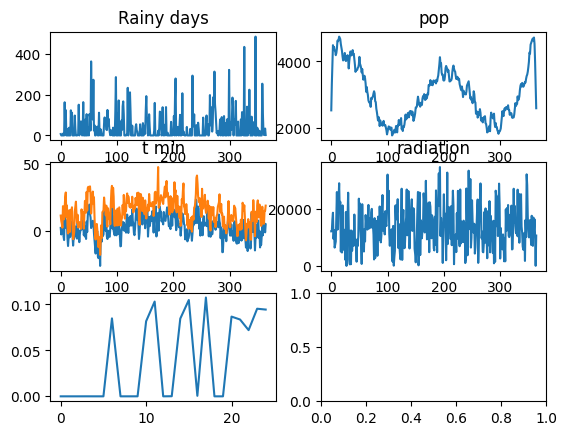

In [5]:
fig1, axs1 = plt.subplots(3, 2)

axs1[0][0].plot(X, dailyRain[0:T] )
axs1[0][0].set_title('Rainy days')

axs1[1][0].plot(X, t_min, t_max)
axs1[1][0].set_title('t min')

axs1[0][1].plot(X,  population.getPopWave() )
axs1[0][1].set_title('pop')

axs1[1][1].plot(X,  radiaz )
axs1[1][1].set_title('radiation')

axs1[2][0].plot([x for x in range(len(tIstants))], Utils.normalizeProbs([s.probability for s in scenarios]))
axs1[2][0]

plt.show()